In [1]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.3 MB 18 kB/s 
     |████████████████████████████████| 462 kB 8.2 MB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import os

from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout,LSTM
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
from keras.utils.vis_utils import plot_model
warnings.filterwarnings('ignore')


In [133]:
train_df=pd.read_csv('/content/drive/MyDrive/soft&pattern/soft/project/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/drive/MyDrive/soft&pattern/soft/project/mitbih_test.csv',header=None)

# Frequency for each class

In [134]:
train_df[187]=train_df[187].astype(int)
print(train_df.shape)
equilibre=train_df[187].value_counts()
print(equilibre)

(87554, 188)
0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


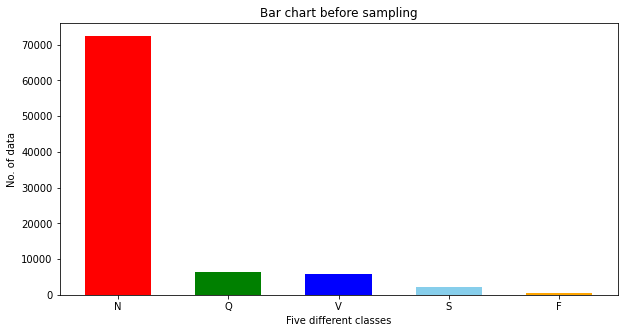

In [135]:
plt.figure(figsize=(10,5))
data = {'N':72471, 'Q':6431, 'V':5788, 'S':2223, 'F':641}
Label = list(data.keys())
values = list(data.values())
plt.bar(Label, values, color =['red','green','blue','skyblue','orange'], width = 0.6)
plt.xlabel("Five different classes")
plt.ylabel("No. of data")
plt.title("Bar chart before sampling")
plt.show()

# Resampling

In [136]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [137]:
equilibre=train_df[187].value_counts()
print(equilibre)


0    20000
1    20000
2    20000
3    20000
4    20000
Name: 187, dtype: int64


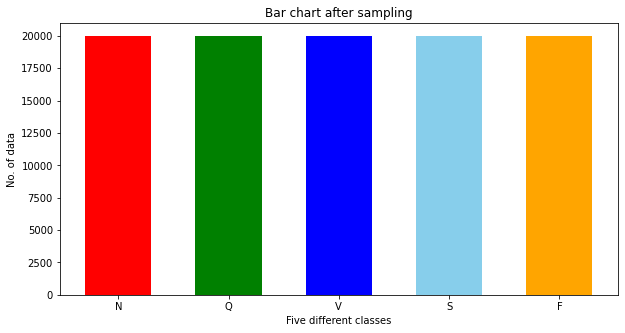

In [138]:
plt.figure(figsize=(10,5))
data = {'N':20000, 'Q':20000, 'V':20000, 'S':20000, 'F':20000}
Label = list(data.keys())
values = list(data.values())
plt.bar(Label, values, color =['red','green','blue','skyblue','orange'], width = 0.6)
plt.xlabel("Five different classes")
plt.ylabel("No. of data")
plt.title("Bar chart after sampling")
plt.show()

# One sample from per class

In [139]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
c

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
49706,0.988914,0.926829,0.738359,0.592018,0.372506,0.195122,0.057650,0.019956,0.011086,0.026608,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0
74422,0.922131,0.831967,0.237705,0.045082,0.118852,0.168033,0.155738,0.188525,0.278689,0.241803,...,0.311475,0.307377,0.32377,0.327869,0.32377,0.303279,0.32377,0.32377,0.315574,1
77530,0.000000,0.085890,0.164110,0.220859,0.306748,0.369632,0.371166,0.368098,0.372699,0.378834,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,2
80823,0.901354,1.000000,0.972921,0.555126,0.266925,0.174081,0.108317,0.106383,0.059961,0.058027,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,3
83714,1.000000,0.528517,0.562738,0.543726,0.562738,0.517110,0.513308,0.422053,0.334601,0.182510,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,4


# ECG Signal Plot

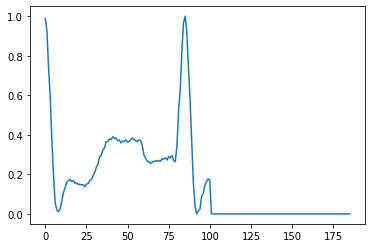

In [140]:
 plt.plot(c.iloc[0,:186])

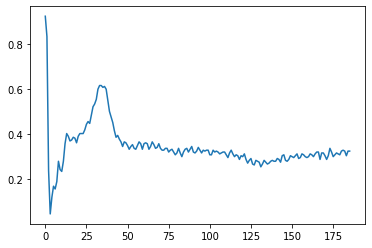

In [141]:
 plt.plot(c.iloc[1,:186])

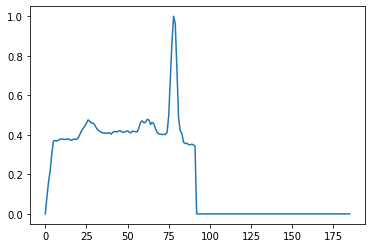

In [142]:
 plt.plot(c.iloc[2,:186])

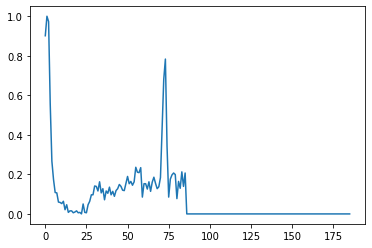

In [143]:
plt.plot(c.iloc[3,:186])

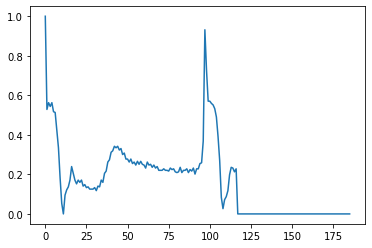

In [144]:
plt.plot(c.iloc[4,:186])

# Transform data

In [145]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [146]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values


In [147]:
np.array(X_train).shape

(100000, 186)

In [148]:
np.array(y_train).shape

(100000, 5)

# **CNN**

In [20]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)

    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)

    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)

    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=50,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history, model.summary())


In [21]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

In [22]:
X_train.shape

(100000, 186)

In [23]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size = 0.10)
model,history,summary=network(X_train,y_train,X_val,y_val)
summary

Epoch 1/50
2813/2813 [==============================] - 29s 8ms/step - loss: 0.1962 - accuracy: 0.9306 - val_loss: 0.1747 - val_accuracy: 0.9401
Epoch 2/50
2813/2813 [==============================] - 28s 10ms/step - loss: 0.0774 - accuracy: 0.9733 - val_loss: 0.0736 - val_accuracy: 0.9758
Epoch 3/50
2813/2813 [==============================] - 18s 6ms/step - loss: 0.0526 - accuracy: 0.9821 - val_loss: 0.0688 - val_accuracy: 0.9781
Epoch 4/50
2813/2813 [==============================] - 18s 6ms/step - loss: 0.0408 - accuracy: 0.9867 - val_loss: 0.0610 - val_accuracy: 0.9796
Epoch 5/50
2813/2813 [==============================] - 18s 6ms/step - loss: 0.0337 - accuracy: 0.9890 - val_loss: 0.0500 - val_accuracy: 0.9845
Epoch 6/50
2813/2813 [==============================] - 17s 6ms/step - loss: 0.0263 - accuracy: 0.9915 - val_loss: 0.0755 - val_accuracy: 0.9749
Epoch 7/50
2813/2813 [==============================] - 18s 6ms/step - loss: 0.0242 - accuracy: 0.9926 - val_loss: 0.0490 - val_a

# Evaluation

Accuracy: 97.92%


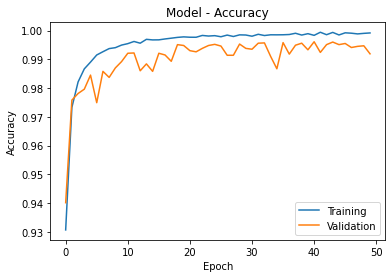

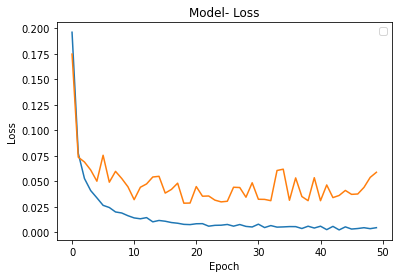

In [77]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

Text(0.5, 1.0, 'CNN Loss & Accuracy Evolution')

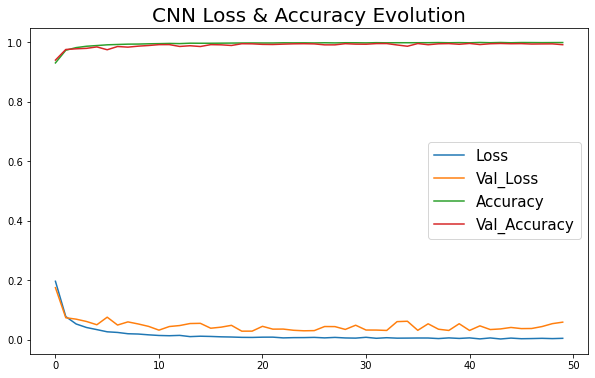

In [79]:
#import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

#plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend(fontsize= 15)
plt.title('CNN Loss & Accuracy Evolution', size = 20)

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.79      0.84      0.81       556
           2       0.93      0.96      0.95      1448
           3       0.65      0.86      0.74       162
           4       0.98      0.99      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.87      0.93      0.89     21892
weighted avg       0.98      0.98      0.98     21892



Normalized confusion matrix


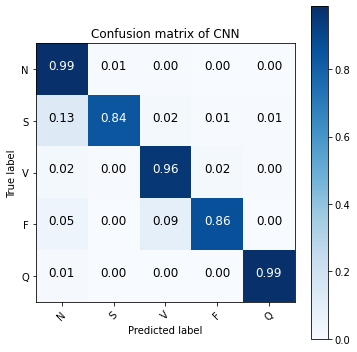

In [93]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), Size = 12,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix of CNN')
plt.show()



In [94]:
print('Precision: %.3f' % precision_score(y_test, y_pred, average='micro'))
print('F1 Score: %.3f' % f1_score(y_test, y_pred, average='micro'))
print('Recall: %.3f' % recall_score(y_test, y_pred, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Precision: 0.979
F1 Score: 0.979
Recall: 0.979
Accuracy: 0.979


# **ALexNet**

In [149]:
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout 
from keras.models import Sequential
import tensorflow as tf

alexNet_model =  Sequential()

alexNet_model.add(Conv1D(filters=96, activation='relu', kernel_size=11, strides=4, input_shape=(186,1)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3, activation='relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3, activation='relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Flatten())
alexNet_model.add(Dense(4096, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(4096, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(5, activation='softmax'))

In [150]:
alexNet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 44, 96)            1152      
                                                                 
 batch_normalization_12 (Bat  (None, 44, 96)           384       
 chNormalization)                                                
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 22, 96)           0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 22, 256)           123136    
                                                                 
 batch_normalization_13 (Bat  (None, 22, 256)          1024      
 chNormalization)                                                
                                                      

In [154]:
alexNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [155]:
X_train.shape

(100000, 186)

In [156]:
y_train.shape

(100000, 5)

In [157]:
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
alexNet_model_history = alexNet_model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/50
3125/3125 [==============================] - 114s 36ms/step - loss: 0.3363 - accuracy: 0.8887 - val_loss: 0.1954 - val_accuracy: 0.9371
Epoch 2/50
3125/3125 [==============================] - 32s 10ms/step - loss: 0.1629 - accuracy: 0.9473 - val_loss: 0.4106 - val_accuracy: 0.9213
Epoch 3/50
3125/3125 [==============================] - 32s 10ms/step - loss: 0.1171 - accuracy: 0.9627 - val_loss: 0.2544 - val_accuracy: 0.9013
Epoch 4/50
3125/3125 [==============================] - 32s 10ms/step - loss: 0.0915 - accuracy: 0.9725 - val_loss: 0.3040 - val_accuracy: 0.8985
Epoch 5/50
3125/3125 [==============================] - 32s 10ms/step - loss: 0.0805 - accuracy: 0.9764 - val_loss: 0.1586 - val_accuracy: 0.9535
Epoch 6/50
3125/3125 [==============================] - 32s 10ms/step - loss: 0.0680 - accuracy: 0.9802 - val_loss: 0.1636 - val_accuracy: 0.9585
Epoch 7/50
3125/3125 [==============================] - 32s 10ms/step - loss: 0.0593 - accuracy: 0.9835 - val_loss: 0.1536 

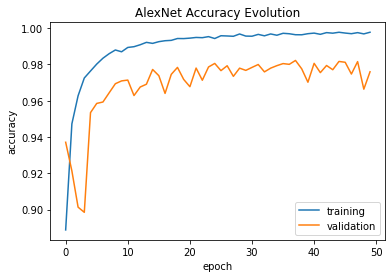

<Figure size 432x288 with 0 Axes>

In [158]:
plt.plot(alexNet_model_history.history['accuracy'])
plt.plot(alexNet_model_history.history['val_accuracy'])
#plt.title('Custom CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.title('AlexNet Accuracy Evolution')
plt.show()
plt.savefig('AlexNetAccuracy.png')

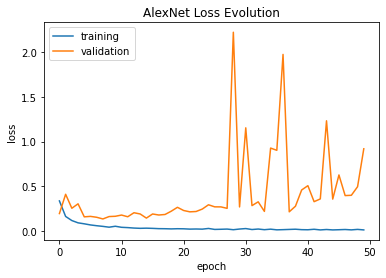

<Figure size 432x288 with 0 Axes>

In [159]:
plt.plot(alexNet_model_history.history['loss'])
plt.plot(alexNet_model_history.history['val_loss'])
#plt.title('Custom CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.title('AlexNet Loss Evolution')
plt.show()
plt.savefig('AlexNetLoss.png')

Text(0.5, 1.0, 'AlexNet Loss & Accuracy Evolution')

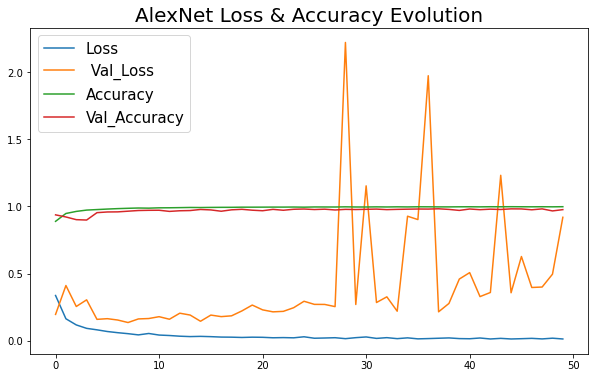

In [160]:
plt.figure(figsize=(10, 6))

#plt.subplot(2, 1, 1)
plt.plot(alexNet_model_history.history['loss'], label='Loss')
plt.plot(alexNet_model_history.history['val_loss'], label=' Val_Loss')
plt.plot(alexNet_model_history.history['accuracy'], label='Accuracy')
plt.plot(alexNet_model_history.history['val_accuracy'], label='Val_Accuracy')
plt.legend(fontsize=15)
plt.title('AlexNet Loss & Accuracy Evolution', size = 20)

In [161]:
y_true_alexnet=[]
for element in y_test:
    y_true_alexnet.append(np.argmax(element))
prediction_proba=alexNet_model.predict(X_test)
prediction_alexnet=np.argmax(prediction_proba,axis=1)

Normalized confusion matrix


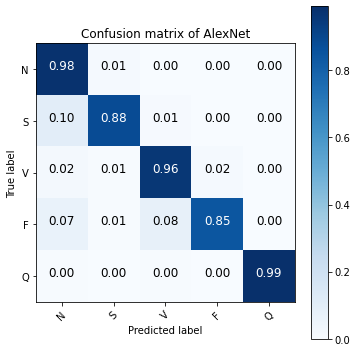

In [163]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), Size = 12,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
alexnetConfMat = confusion_matrix(y_true_alexnet, prediction_alexnet)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(alexnetConfMat, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix of AlexNet')
plt.show()


In [164]:
print('Precision: %.3f' % precision_score(y_true_alexnet, prediction_alexnet, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true_alexnet, prediction_alexnet, average='micro'))
print('Recall: %.3f' % recall_score(y_true_alexnet, prediction_alexnet, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true_alexnet, prediction_alexnet))

Precision: 0.976
F1 Score: 0.976
Recall: 0.976
Accuracy: 0.976


# **LSTM**

In [165]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(186,1)))
lstm_model.add(Dense(128, activation = 'relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(5, activation = 'softmax'))

In [166]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense_14 (Dense)            (None, 128)               8320      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 5)                 645       
                                                                 
Total params: 25,861
Trainable params: 25,861
Non-trainable params: 0
_________________________________________________________________


In [167]:
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [168]:
X_train.shape

(100000, 186)

In [169]:
y_train.shape

(100000, 5)

In [170]:
lstm_model_history = lstm_model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/50
3125/3125 [==============================] - 30s 9ms/step - loss: 1.0963 - accuracy: 0.5656 - val_loss: 1.1693 - val_accuracy: 0.5355
Epoch 2/50
3125/3125 [==============================] - 29s 9ms/step - loss: 0.8498 - accuracy: 0.6837 - val_loss: 1.0559 - val_accuracy: 0.6057
Epoch 3/50
3125/3125 [==============================] - 27s 9ms/step - loss: 0.7449 - accuracy: 0.7295 - val_loss: 0.8638 - val_accuracy: 0.6950
Epoch 4/50
3125/3125 [==============================] - 27s 9ms/step - loss: 0.6804 - accuracy: 0.7559 - val_loss: 0.9890 - val_accuracy: 0.6343
Epoch 5/50
3125/3125 [==============================] - 27s 9ms/step - loss: 0.6568 - accuracy: 0.7670 - val_loss: 0.6650 - val_accuracy: 0.7681
Epoch 6/50
3125/3125 [==============================] - 27s 9ms/step - loss: 0.5433 - accuracy: 0.8115 - val_loss: 0.8579 - val_accuracy: 0.7385
Epoch 7/50
3125/3125 [==============================] - 27s 9ms/step - loss: 0.5087 - accuracy: 0.8239 - val_loss: 0.7736 - val_ac

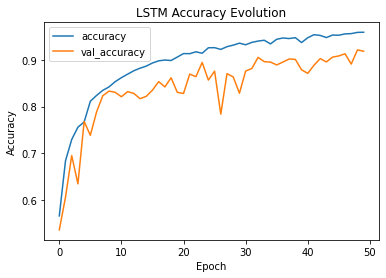

In [171]:
plt.plot(lstm_model_history.history['accuracy'])
plt.plot(lstm_model_history.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Accuracy Evolution')
plt.savefig('LSTMaccuracy.png')

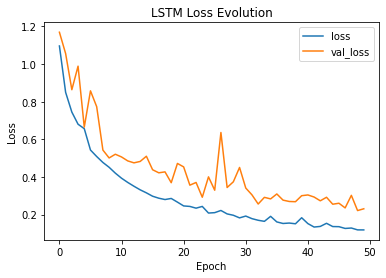

In [172]:
plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Loss Evolution')
plt.savefig('LSTMLoss.png')

Text(0.5, 1.0, 'LSTM Loss & Accuracy Evolution')

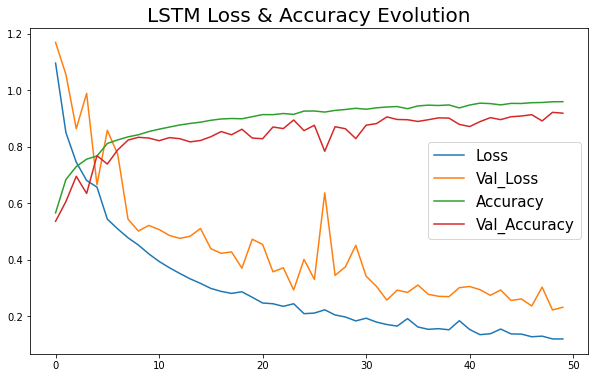

In [174]:
plt.figure(figsize=(10, 6))

#plt.subplot(2, 1, 1)
plt.plot(lstm_model_history.history['loss'], label='Loss')
plt.plot(lstm_model_history.history['val_loss'], label='Val_Loss')
plt.plot(lstm_model_history.history['accuracy'], label='Accuracy')
plt.plot(lstm_model_history.history['val_accuracy'], label='Val_Accuracy')
plt.legend(fontsize = 15)
plt.title('LSTM Loss & Accuracy Evolution', size = 20)

In [175]:
y_true_lstm=[]
for element in y_test:
    y_true_lstm.append(np.argmax(element))
prediction_proba=lstm_model.predict(X_test)
prediction_lstm=np.argmax(prediction_proba,axis=1)

Normalized confusion matrix


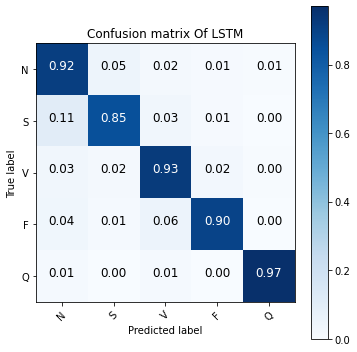

In [177]:
SIZE = 8
lstmconfmat = confusion_matrix(y_true_lstm, prediction_lstm)
# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(lstmconfmat, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix Of LSTM')
plt.show()



In [178]:
print('Precision: %.3f' % precision_score(y_true_lstm, prediction_lstm, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true_lstm, prediction_lstm, average='micro'))
print('Recall: %.3f' % recall_score(y_true_lstm, prediction_lstm, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true_lstm, prediction_lstm))

Precision: 0.919
F1 Score: 0.919
Recall: 0.919
Accuracy: 0.919


# **LeNet**

In [179]:
lenet_model=Sequential()

lenet_model.add(Conv1D(filters=6, kernel_size=3, padding='same', activation='relu', input_shape=(186,1)))
lenet_model.add(BatchNormalization())
lenet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_model.add(Conv1D(filters=16, strides=1, kernel_size=5, activation='relu'))
lenet_model.add(BatchNormalization())
lenet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_model.add(Flatten())

lenet_model.add(Dense(64, activation='relu'))

lenet_model.add(Dense(32, activation='relu'))

lenet_model.add(Dense(5, activation = 'softmax'))

In [180]:
lenet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_23 (Conv1D)          (None, 186, 6)            24        
                                                                 
 batch_normalization_15 (Bat  (None, 186, 6)           24        
 chNormalization)                                                
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 93, 6)            0         
 g1D)                                                            
                                                                 
 conv1d_24 (Conv1D)          (None, 89, 16)            496       
                                                                 
 batch_normalization_16 (Bat  (None, 89, 16)           64        
 chNormalization)                                                
                                                      

In [181]:
lenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [182]:
X_train.shape

(100000, 186)

In [183]:
y_train.shape

(100000, 5)

In [184]:
lenet_model_history = lenet_model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/50
3125/3125 [==============================] - 16s 5ms/step - loss: 0.2157 - accuracy: 0.9226 - val_loss: 0.2485 - val_accuracy: 0.9155
Epoch 2/50
3125/3125 [==============================] - 13s 4ms/step - loss: 0.0844 - accuracy: 0.9710 - val_loss: 0.1763 - val_accuracy: 0.9468
Epoch 3/50
3125/3125 [==============================] - 13s 4ms/step - loss: 0.0543 - accuracy: 0.9819 - val_loss: 0.1446 - val_accuracy: 0.9609
Epoch 4/50
3125/3125 [==============================] - 13s 4ms/step - loss: 0.0418 - accuracy: 0.9861 - val_loss: 0.1491 - val_accuracy: 0.9660
Epoch 5/50
3125/3125 [==============================] - 14s 5ms/step - loss: 0.0345 - accuracy: 0.9886 - val_loss: 0.1837 - val_accuracy: 0.9545
Epoch 6/50
3125/3125 [==============================] - 14s 5ms/step - loss: 0.0288 - accuracy: 0.9904 - val_loss: 0.1958 - val_accuracy: 0.9558
Epoch 7/50
3125/3125 [==============================] - 14s 5ms/step - loss: 0.0242 - accuracy: 0.9923 - val_loss: 0.1609 - val_ac

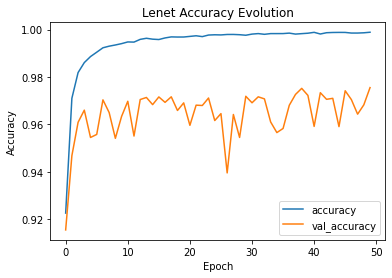

In [185]:
plt.plot(lenet_model_history.history['accuracy'])
plt.plot(lenet_model_history.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Lenet Accuracy Evolution')
plt.savefig('Lenet Accuracy.png')

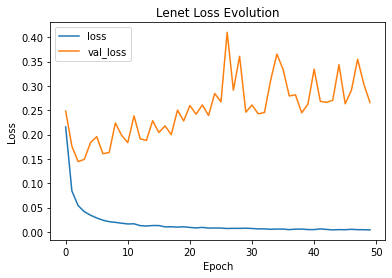

In [186]:
plt.plot(lenet_model_history.history['loss'])
plt.plot(lenet_model_history.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Lenet Loss Evolution')
plt.savefig('Lenet Loss.png')

Text(0.5, 1.0, 'LeNet Loss & Accuracy Evolution')

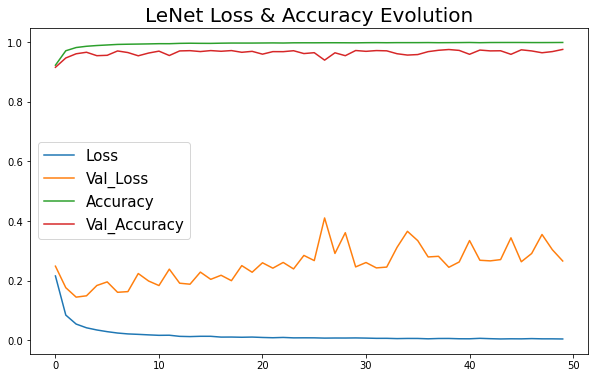

In [187]:
plt.figure(figsize=(10, 6))

#plt.subplot(2, 1, 1)
plt.plot(lenet_model_history.history['loss'], label='Loss')
plt.plot(lenet_model_history.history['val_loss'], label='Val_Loss')
plt.plot(lenet_model_history.history['accuracy'], label='Accuracy')
plt.plot(lenet_model_history.history['val_accuracy'], label='Val_Accuracy')
plt.legend(fontsize = 15)
plt.title('LeNet Loss & Accuracy Evolution',size = 20)

In [188]:
y_true_lenet=[]
for element in y_test:
    y_true_lenet.append(np.argmax(element))
prediction_proba=lenet_model.predict(X_test)
prediction_lenet=np.argmax(prediction_proba,axis=1)

Normalized confusion matrix


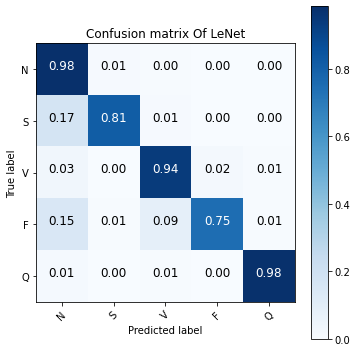

In [189]:
SIZE = 8
lenetconfmat = confusion_matrix(y_true_lenet, prediction_lenet)
# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(lenetconfmat, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix Of LeNet')
plt.show()


In [190]:
print('Precision: %.3f' % precision_score(y_true_lenet, prediction_lenet, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true_lenet, prediction_lenet, average='micro'))
print('Recall: %.3f' % recall_score(y_true_lenet, prediction_lenet, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true_lenet, prediction_lenet))

Precision: 0.976
F1 Score: 0.976
Recall: 0.976
Accuracy: 0.976


# ***VGG***

In [191]:
vgg_model=Sequential()

vgg_model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu',  input_shape=(186,1)))
vgg_model.add(BatchNormalization())
vgg_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(Conv1D(filters=512, kernel_size=1, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(Conv1D(filters=512, kernel_size=1, activation='relu', padding='same'))
vgg_model.add(BatchNormalization())
vgg_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_model.add(Flatten())
vgg_model.add(Dense(4096, activation='relu'))
vgg_model.add(Dropout(0.4))
vgg_model.add(Dense(4096, activation='relu'))
vgg_model.add(Dropout(0.4))
vgg_model.add(Dense(5, activation='softmax'))

In [192]:
vgg_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_25 (Conv1D)          (None, 186, 64)           256       
                                                                 
 batch_normalization_17 (Bat  (None, 186, 64)          256       
 chNormalization)                                                
                                                                 
 conv1d_26 (Conv1D)          (None, 186, 64)           12352     
                                                                 
 batch_normalization_18 (Bat  (None, 186, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 93, 64)           0         
 g1D)                                                            
                                                      

In [193]:
X_train.shape

(100000, 186)

In [194]:
y_train.shape

(100000, 5)

In [195]:
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model_history = vgg_model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/50
3125/3125 [==============================] - 83s 25ms/step - loss: 0.4129 - accuracy: 0.8717 - val_loss: 0.2069 - val_accuracy: 0.9376
Epoch 2/50
3125/3125 [==============================] - 75s 24ms/step - loss: 0.2206 - accuracy: 0.9303 - val_loss: 0.3150 - val_accuracy: 0.9156
Epoch 3/50
3125/3125 [==============================] - 73s 23ms/step - loss: 0.1546 - accuracy: 0.9532 - val_loss: 0.2226 - val_accuracy: 0.9228
Epoch 4/50
3125/3125 [==============================] - 74s 24ms/step - loss: 0.1176 - accuracy: 0.9657 - val_loss: 0.2994 - val_accuracy: 0.9052
Epoch 5/50
3125/3125 [==============================] - 74s 24ms/step - loss: 0.1050 - accuracy: 0.9705 - val_loss: 0.1179 - val_accuracy: 0.9675
Epoch 6/50
3125/3125 [==============================] - 74s 24ms/step - loss: 0.0799 - accuracy: 0.9773 - val_loss: 0.1287 - val_accuracy: 0.9599
Epoch 7/50
3125/3125 [==============================] - 74s 24ms/step - loss: 0.0615 - accuracy: 0.9822 - val_loss: 0.1366 -

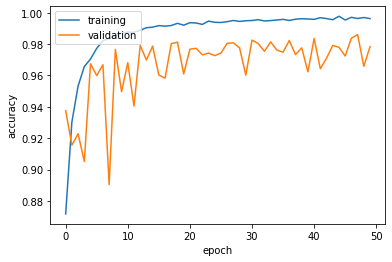

<Figure size 432x288 with 0 Axes>

In [196]:
# summarize history for accuracy
plt.plot(vgg_model_history.history['accuracy'])
plt.plot(vgg_model_history.history['val_accuracy'])
#plt.title('Custom CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.savefig('vgg Accuracy.png')


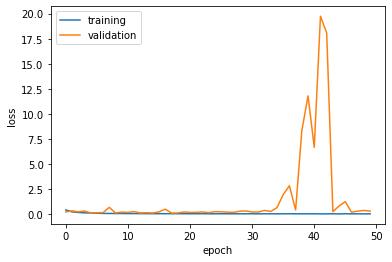

<Figure size 432x288 with 0 Axes>

In [197]:
plt.plot(vgg_model_history.history['loss'])
plt.plot(vgg_model_history.history['val_loss'])
#plt.title('Custom CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.savefig('vgg Loss.png')

Text(0.5, 1.0, 'VGG Loss & Accuracy Evolution')

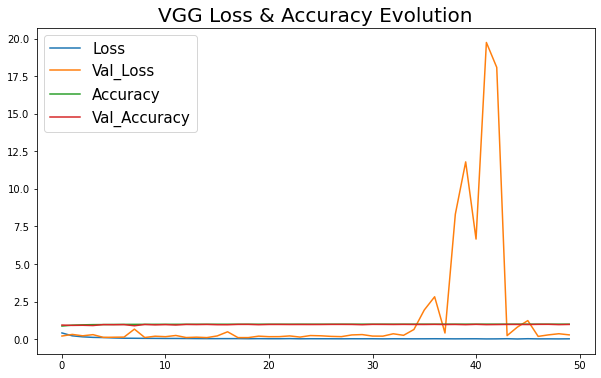

In [198]:
plt.figure(figsize=(10, 6))

#plt.subplot(2, 1, 1)
plt.plot(vgg_model_history.history['loss'], label='Loss')
plt.plot(vgg_model_history.history['val_loss'], label='Val_Loss')
plt.plot(vgg_model_history.history['accuracy'], label='Accuracy')
plt.plot(vgg_model_history.history['val_accuracy'], label='Val_Accuracy')
plt.legend(fontsize = 15)
plt.title('VGG Loss & Accuracy Evolution',size = 20)

In [199]:
y_true_vgg=[]
for element in y_test:
    y_true_vgg.append(np.argmax(element))
prediction_proba=vgg_model.predict(X_test)
prediction_vgg=np.argmax(prediction_proba,axis=1)


Normalized confusion matrix


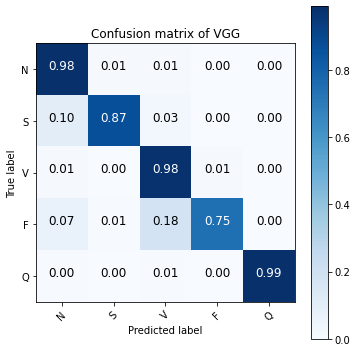

In [200]:
SIZE = 8
vggConfMat = confusion_matrix(y_true_vgg, prediction_vgg)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(vggConfMat, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix of VGG')
plt.show()

In [201]:
print('Precision: %.3f' % precision_score(y_true_vgg, prediction_vgg, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true_vgg, prediction_vgg, average='micro'))
print('Recall: %.3f' % recall_score(y_true_vgg, prediction_vgg, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true_vgg, prediction_vgg))

Precision: 0.978
F1 Score: 0.978
Recall: 0.978
Accuracy: 0.978
